#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 03
**Also good to know section, power loaw distribution**

using the city-size-japan dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/city-size-japan/clean/"
data_out = dirname + "da_case_studies/ch03-city-size-japan/"
output = dirname + "da_case_studies/ch03-city-size-japan/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
import py_helper_functions as da
sns.set_theme(rc=da.da_theme, palette=da.color)

In [5]:
city_size = pd.read_csv(data_in + "city-size-japan.csv")
city_size

,Name,pop_1995,pop_2000,pop_2005,pop_2010,pop_2015
0,Ageo,206090,212947,220232,223926,225196
1,Akashi,287606,293117,291027,290959,293409
2,Akita,331597,336646,333109,323600,315814
3,Amagasaki,488586,466187,462647,453748,452563
4,Anj?,149464,158824,170250,178691,184140
...,...,...,...,...,...,...
154,Yamato,203933,212761,221220,228186,232922
155,Yao,276664,274777,273487,271460,268800
156,Yokkaichi,296623,302102,303845,307766,311031
157,Yokohama,3307136,3426651,3579628,3688773,3724844


#### Create variables

In [6]:
city_size["pop"] = city_size["pop_2015"] / 1000
city_size["lnpop"] = np.log(city_size["pop"])
city_size.head()

,Name,pop_1995,pop_2000,pop_2005,pop_2010,pop_2015,pop,lnpop
0,Ageo,206090,212947,220232,223926,225196,225.196,5.416971
1,Akashi,287606,293117,291027,290959,293409,293.409,5.681568
2,Akita,331597,336646,333109,323600,315814,315.814,5.755153
3,Amagasaki,488586,466187,462647,453748,452563,452.563,6.114927
4,Anj?,149464,158824,170250,178691,184140,184.140,5.215696


In [ ]:
# city_size = city_size.sort_values(by="pop", ascending=False).reset_index(drop=True)
# city_size["rank"] = [x for x in range(1, city_size.shape[0] + 1)]
# city_size["lnrank"] = np.log(city_size["rank"])
# city_size.head()

,Name,pop_1995,pop_2000,pop_2005,pop_2010,pop_2015,pop,lnpop,rank,lnrank
0,T?ky? [Tokyo],7967614,8134688,8489653,8945695,9272740,9272.740,9.134834,1,0.000000
1,Yokohama,3307136,3426651,3579628,3688773,3724844,3724.844,8.222780,2,0.693147
2,?saka [Osaka],2602421,2598774,2628811,2665314,2691185,2691.185,7.897737,3,1.098612
3,Nagoya,2152184,2171557,2215062,2263894,2295638,2295.638,7.738766,4,1.386294
4,Sapporo,1757025,1822368,1880863,1913545,1952356,1952.356,7.576792,5,1.609438


### 🕵️‍♀️ Bellonda's Logic Decoder: "Method Chaining"
**The Business Goal:** Make data transformation readable, faster, and less error-prone by avoiding multiple variable overwrites.

**The Syntax Anatomy:**
* `( ... )` → **The Wrapper** (Allows multi-line chaining without `\` characters)
* `.reset_index(drop=True)` → **The Cleaner** (Crucial: sets up the index to be used as a numerical generator)
* `.assign()` → **The Creator** (Generates multiple columns at once)
* `lambda df:` → **The Connector** (Accesses the *current* state of the data inside the chain, before it is saved back to the variable)

> **💡 The Wisdom Check:**
> **The Index is a Tool, not just a label.**
> By resetting the index on sorted data, we get a free "Rank" generator (`df.index + 1`). We replaced a slow loop with fast vector math just by being clever with the Index.

In [ ]:
# We wrap the whole chain in parentheses (). 
# This lets us break lines without ugly '\' characters.
# It makes the logic read like a recipe from top to bottom.
city_size = (
    city_size
    # 1. SORTING
    # First, we get the data in the right order (biggest pop first).
    # This is standard SQL "ORDER BY pop DESC".
    .sort_values(by="pop", ascending=False)

    # 2. RESETTING THE INDEX
    # This is the secret sauce! 
    # By dropping the old index, we generate a fresh default index: 0, 1, 2, 3...
    # This effectively creates our "row number" for us automatically.
    .reset_index(drop=True) #drop (default: False): If True, removes the old index instead of adding it as a column.
    # 3. THE ASSIGN METHOD (The Loop Killer)
    # .assign() creates new columns and returns a copy of the dataframe.
    # We use 'lambda df:' to access the dataframe *as it exists at this specific step* # in the chain (sorted and re-indexed), NOT the original variable 'city_size'.
    .assign(
        
        # COLUMN A: 'rank'
        # Instead of `[x for x in range...]`, we simply take the index (0, 1, 2...)
        # and add 1 to the whole array at once. 
        # Pandas pushes this math to C-level speeds. No Python loop required.
        rank=lambda df: df.index + 1,

        # COLUMN B: 'lnrank'
        # Because .assign() processes arguments in order (Python 3.6+),
        # we can immediately use the 'rank' column we *just* created above!
        # We pass that column array into numpy's log function for instant calculation.
        lnrank=lambda df: np.log(df["rank"])
    )
)

# 4. THE REVEAL
# Display the first few rows to verify our handiwork.
city_size.head()

,Name,pop_1995,pop_2000,pop_2005,pop_2010,pop_2015,pop,lnpop,rank,lnrank
0,T?ky? [Tokyo],7967614,8134688,8489653,8945695,9272740,9272.740,9.134834,1,0.000000
1,Yokohama,3307136,3426651,3579628,3688773,3724844,3724.844,8.222780,2,0.693147
2,?saka [Osaka],2602421,2598774,2628811,2665314,2691185,2691.185,7.897737,3,1.098612
3,Nagoya,2152184,2171557,2215062,2263894,2295638,2295.638,7.738766,4,1.386294
4,Sapporo,1757025,1822368,1880863,1913545,1952356,1952.356,7.576792,5,1.609438


#### ln(rank) vs ln(population) plot

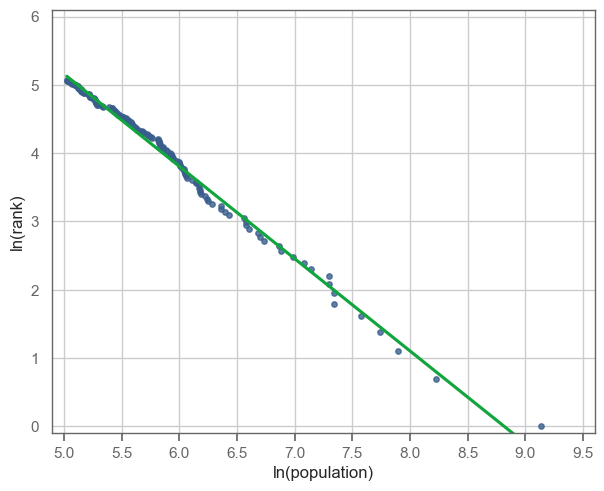

In [ ]:
# Create a regression plot using seaborn
fig = sns.regplot(
    x="lnpop",  # The column name for the x-axis (log of population)
    y="lnrank",  # The column name for the y-axis (log of rank)
    data=city_size,  # The DataFrame containing the data
    scatter_kws={"s": 15},  # Keyword arguments for the scatter plot points (s=size)
    line_kws={"color": da.color[1]},  # Keyword arguments for the regression line (set color)
    ci=None,  # Disable the confidence interval shading around the line
)

# Set the label for the x-axis
plt.xlabel("ln(population)")
# Set the label for the y-axis
plt.ylabel("ln(rank)")

# Set the limits for the y-axis (min, max)
plt.ylim(-0.1, 6.1)
# Set the specific tick marks to display on the y-axis
plt.yticks(np.arange(0, 7, 1))

# Set the limits for the x-axis (min, max)
plt.xlim(4.9, 9.6)
# Set the specific tick marks to display on the x-axis
plt.xticks(np.arange(5, 9.6, 0.5))

# Display the final plot
plt.show()

#### scale invariance


In [8]:
x1 = 200
x2 = 300
bound = 0.2

In [9]:
city_size.loc[
    (city_size["pop"] >= x1 * (1 - bound)) & (city_size["pop"] <= x1 * (1 + bound))
].shape[0]

56

In [10]:
city_size.loc[
    (city_size["pop"] >= x2 * (1 - bound)) & (city_size["pop"] <= x2 * (1 + bound))
].shape[0]

37

In [11]:
shift = 3
x3 = x1 * shift
x4 = x2 * shift

In [12]:
city_size.loc[
    (city_size["pop"] >= x3 * (1 - bound)) & (city_size["pop"] <= x3 * (1 + bound))
].shape[0]

13

In [13]:
city_size.loc[
    (city_size["pop"] >= x4 * (1 - bound)) & (city_size["pop"] <= x4 * (1 + bound))
].shape[0]

7